In [2]:
# To see which modules I'm missing
# !pip3  install --upgrade tensorflow==1.15.0
# !pip3 install tensorflow_hub

In [3]:
# Installing waymo's open dataset
!pip3 install waymo-open-dataset

# Installing RESNET layer
!pip3 install tensorflow_hub


# Importing libraries
import os
import tensorflow as tf
import math
import numpy as np
import itertools
import glob
import IPython
from PIL import Image, ImageOps
import time
import sys

# No need to enable for TF1.15 and above and TF2
tf.enable_eager_execution()

# Don't have these utils below because Waymo was using TF1 instead of TF2
# from waymo_open_dataset.utils import range_image_utils
# from waymo_open_dataset.utils import transform_utils
# from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.



## Reading one frame

In [4]:
FILENAME = 'segment-169115044301335945_480_000_500_000_with_camera_labels.tfrecord'
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    break

In [5]:
# (range_images, camera_projections, range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(frame)

## Examining frame context

In [6]:
print(frame.context)

name: "169115044301335945_480_000_500_000"
camera_calibrations {
  name: FRONT
  intrinsic: 2055.556149361639
  intrinsic: 2055.556149361639
  intrinsic: 939.6574698861468
  intrinsic: 641.0721821943271
  intrinsic: 0.03231600849798887
  intrinsic: -0.3214124825527059
  intrinsic: 0.0007932583953709973
  intrinsic: -0.0006257493541333847
  intrinsic: 0.0
  extrinsic {
    transform: 0.9998926849887427
    transform: -0.005993208400016058
    transform: 0.0133678704017097
    transform: 1.5389142447125008
    transform: 0.006042236521329663
    transform: 0.9999751560547995
    transform: -0.003630241176497072
    transform: -0.02363394083934774
    transform: -0.013345781499156929
    transform: 0.003710623431877962
    transform: 0.999904056092345
    transform: 2.115270572975561
    transform: 0.0
    transform: 0.0
    transform: 0.0
    transform: 1.0
  }
  width: 1920
  height: 1280
  rolling_shutter_direction: LEFT_TO_RIGHT
}
camera_calibrations {
  name: FRONT_LEFT
  intrinsic: 

## Displaying and saving images to jpg

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_camera_image(camera_image, camera_labels, layout, cmap=None):
    """Show a camera image and the given camera labels."""

    ax = plt.subplot(*layout)

    # Draw the camera labels.
    for camera_labels in frame.camera_labels:
        # Ignore camera labels that do not correspond to this camera.
        if camera_labels.name != camera_image.name:
            continue

        # Iterate over the individual labels.
        for label in camera_labels.labels:
            # Draw the object bounding box.
            ax.add_patch(patches.Rectangle(
            xy=(label.box.center_x - 0.5 * label.box.length,
                label.box.center_y - 0.5 * label.box.width),
            width=label.box.length,
            height=label.box.width,
            linewidth=1,
            edgecolor='red',
            facecolor='none'))

    # Show the camera image.
    plt.imshow(tf.image.decode_jpeg(camera_image.image), cmap=cmap)
    plt.title(open_dataset.CameraName.Name.Name(camera_image.name))
    plt.grid(False)
    plt.axis('off')
    
    # Increasing the size of the plot
    fig = plt.gcf()
    fig.set_size_inches(50,60)
    
    # Saving the image to png format to work with later
    # Have to use fig instead of plt because plt doesn't have the adjusted sizing
    # Have to use bbox_inches = tight to avoid saving white space around image
    fig.savefig('Waymo_images/image_{}.jpg'.format(camera_image.name), bbox_inches='tight')
    
    plt.show()

for index, image in enumerate(frame.images):
    show_camera_image(image, frame.camera_labels, [3, 3, index+1])

<Figure size 5000x6000 with 1 Axes>

<Figure size 5000x6000 with 1 Axes>

<Figure size 5000x6000 with 1 Axes>

<Figure size 5000x6000 with 1 Axes>

<Figure size 5000x6000 with 1 Axes>

In [8]:
# Checking images were saved correctly

# Timing how long it takes to load data
start = time.time()

globbed_path = glob.glob('*/*.jpg') + glob.glob('*/*.JPG')
print('There are ', len(globbed_path), ' image files in the Waymo folder.')

extract = time.time()
print('Time taken for extraction: {}s'.format(extract-start), '\n')

There are  5  image files in the Waymo folder.
Time taken for extraction: 0.0014805793762207031s 



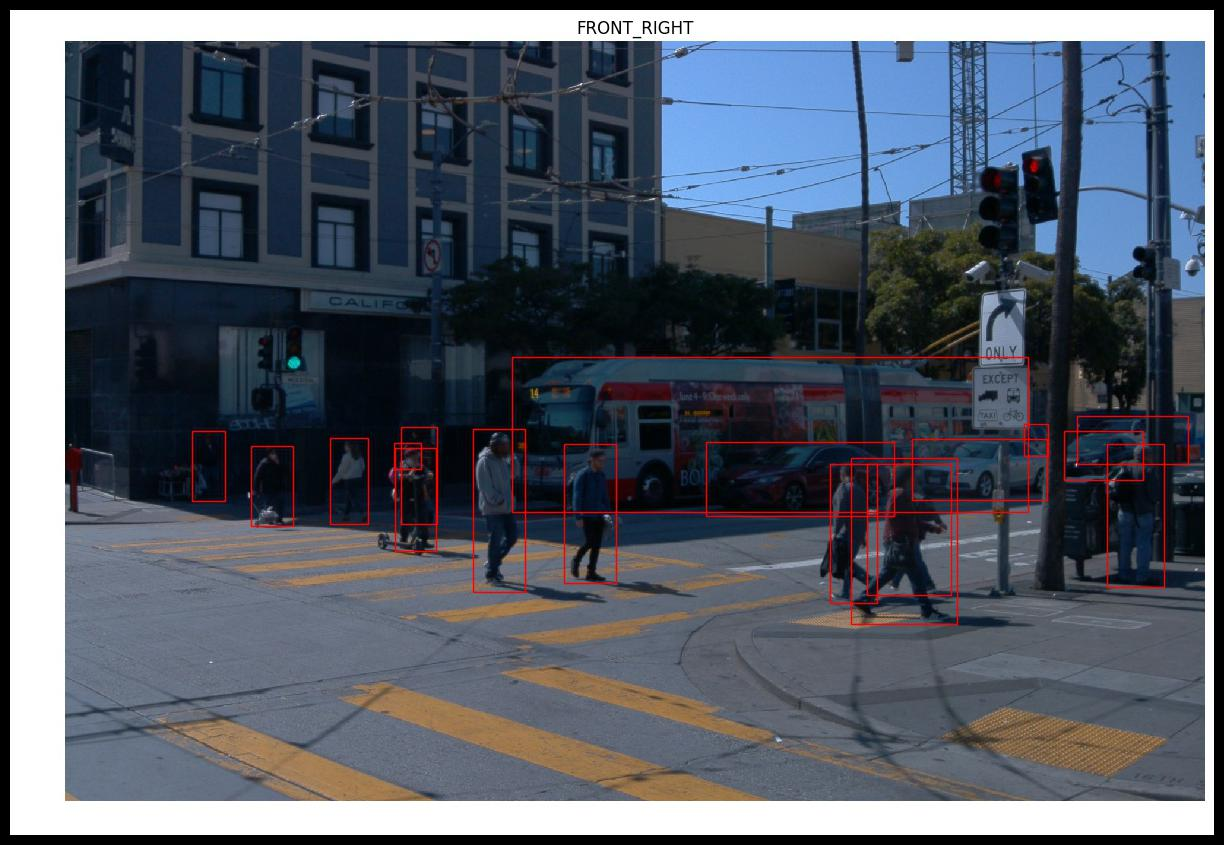

In [9]:
# Adding a border to assess where the image ends

ImageOps.expand(Image.open(globbed_path[0]),border=10,fill='black').save('image_1_border.jpg')
IPython.display.Image(filename = 'image_1_border.jpg')


## Resizing images for assessment by pre-trained RESNET models

In [10]:
# Helper function to crop image centers

def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

In [11]:
# Cropping Waymo photos to requisite size to test on resnet

# Timing how long it takes to load data
start = time.time()

## load extracted waymo dataset
WAYMO_PATH = 'Waymo_images'

waymo_test = []

globbed_path = glob.glob('*/*.jpg') + glob.glob('*/*.JPG')
print('There are ', len(globbed_path), ' image files in the Waymo folder.')

extract = time.time()
print('Time taken for extraction: {}s'.format(extract-start), '\n')

# Resizing the image
for impath in globbed_path:
    im = Image.open(impath)
    w, h = im.size
#     print(im.size)
    im = crop_center(im, min(w,h), min(w,h))
    im = im.resize((224,224))
    im = np.asarray(im)/256.0
    if im.shape == (224, 224, 3):
        waymo_test.append(im)
#         taco_train_Y.append(0)   # TACO images are labelled 0

print('There are ', len(waymo_test), ' images in the Waymo test dataset.')
print('Time taken for resizing: {}s'.format(time.time()-extract))

There are  5  image files in the Waymo folder.
Time taken for extraction: 0.0010554790496826172s 

There are  5  images in the Waymo test dataset.
Time taken for resizing: 0.08292675018310547s


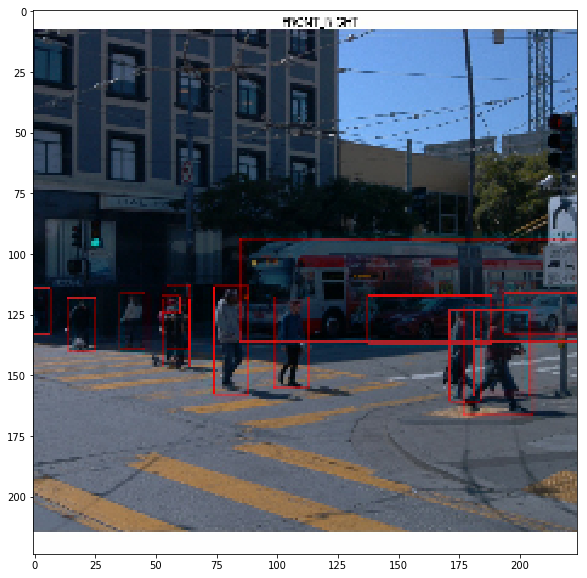

In [12]:
# Image after resizing

plt.figure(figsize = (10,10))
plt.imshow(waymo_test[0], interpolation='nearest')
plt.show()

# Seems reasonable, i don't lose out too much of the picture
# But note images are of low quality

## Loading pre-trained model and testing on Waymo images

In [13]:
# Keras
import tensorflow as tf
import tensorflow_hub as hub

import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


In [14]:
# Loading earlier pre-trained models

resnet20 = tf.keras.models.load_model('best_resnet2.h5',custom_objects={'KerasLayer':hub.KerasLayer})
print(resnet20.summary())

resnet40 = tf.keras.models.load_model('best_resnet3.h5',custom_objects={'KerasLayer':hub.KerasLayer})
print(resnet40.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   multiple                  23561152  
_________________________________________________________________
dense_2 (Dense)              multiple                  2049      
Total params: 23,563,201
Trainable params: 2,049
Non-trainable params: 23,561,152
_________________________________________________________________
None


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   multiple                  23561152  
_________________________________________________________________
dense_3 (Dense)              multiple                  2049      
Total params: 23,563,201
Trainable params: 2,049
Non-trainable params: 23,561,152
_________________________________________________________________
None


In [38]:
# Converting waymo_test from list to array for prediction
waymo_arr = np.array(waymo_test)

# Cannot use lists
# https://github.com/keras-team/keras/issues/9475
# I had this trouble on a later version of tensorflow/keras, but not with an earlier version. The later version was on Sagemaker with Python 3.6, keras 2.2.4, tensorflow 1.12. The trick was to update the arrays to np.array:
# x=np.array(x)
# y=np.array(y)

In [29]:
# # Predicting on only one image

# single = waymo_arr2[0]

# # Converting to 4d to fit expected input
# single = np.expand_dims(single, axis = 0)
# print(np.shape(single))

# Testing RESNET model on 1 frame of 5 images
# probs20 = resnet20.predict(single, verbose = 1, batch_size = 1)

(1, 224, 224, 3)

In [41]:
# Predicting using RESNET trained over 20 epochs on TACO and COCO
probs20 = resnet20.predict(waymo_arr, verbose = 1, batch_size = 1)

# Predicting probabilities of trash
print(probs20)

5/1 [======================================================================================================================================================] - 0s 49ms/sample
[[0.99470115]
 [0.99218166]
 [0.93343246]
 [0.99305254]
 [0.9949649 ]]


In [42]:
# Predicting using RESNET trained over 20 epochs on TACO and COCO
probs40 = resnet40.predict(waymo_arr, verbose = 1, batch_size = 1)

# Predicting probabilities of trash
print(probs40)

# Doesn't really look like RESNET40 is a lot more accurate than resnet20

5/1 [======================================================================================================================================================] - 2s 340ms/sample
[[0.9840119 ]
 [0.9638997 ]
 [0.99208283]
 [0.9766814 ]
 [0.9907706 ]]


## Testing for entire tfrecord slice

In [34]:
# Reading multiple frames

FILENAME = 'segment-169115044301335945_480_000_500_000_with_camera_labels.tfrecord'
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
for index, data in enumerate(dataset):
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    
    if index == 3:
        break

In [35]:
(range_images, camera_projections, range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(frame)

NameError: name 'frame_utils' is not defined

In [ ]:
# Things to do
# Convert images to a workable type DONE
# crop images to required size - examine whether the cropping is acceptable DONE - but image of poor quality
# save images to a test data set DONE
# deploy earlier saved models to classify DONE
# repeat for entire tfrecord slice

# Other things to do
# Train new model on this waymo data set, manually annotate pictures 
# Try using Mask R-CNN trained on COCO to segment waymo images into different parts - ask Pedro for his pre-trained model


# Robotics
# Look into which robots can be programmed to move around and pick trash
# Considerations: battery life, collision avoidance/navigation, arm to pick up stuff, storage to hold onto trash



In [ ]:
# On robots

# Lots of kits, mostly a few hundred bucks
# Unsure about battery life, but there are NNs which are lighter
# 
# Most robots don't have storage
# What we could do is a limited demo 

In [ ]:
frame.camera_labels.name()

In [ ]:
for image in frame.images:
    print (image.name)

In [ ]:
for label in frame.camera_labels:
    print(label.name)

In [ ]:
frame.context

In [ ]:
from google.protobuf.json_format import MessageToJson
from google.protobuf.json_format import MessageToDict

# serialized = MessageToJson(original)

response = []

for image in frame.images:
    
    response = MessageToDict(image, preserving_proto_field_name = True)
#     desired_res = response["label_annotation"]
    
    print(type(response))
    print(response)
    print('\n\n\n')
    


In [ ]:
print(frame)

In [ ]:
# Show the camera image.
plt.imshow(tf.image.decode_jpeg(response), cmap=cmap)
plt.title(open_dataset.CameraName.Name.Name(camera_image.name))
plt.grid(False)
plt.axis('off')

# Increasing the size of the plot
fig = plt.gcf()
fig.set_size_inches(50,60)
plt.show()

#### For evaluating a model if we annotate the Waymo data set
for model in models:

    saved_model = load_model(model)
    print('Model:', model)
    u_loss, u_acc = saved_model.evaluate(mini_test_u_x_seq, mini_test_u_y_cat)
    b_loss, b_acc = saved_model.evaluate(mini_test_b_x_seq, mini_test_b_y_cat)
    
    print('Unbalanced accuracy: {}   loss: {}'.format(u_acc, u_loss))
    print('Balanced accuracy: {}   loss: {} \n\n'.format(b_acc, b_loss))

#### How to export models properly to avoid ValueError of not having keraslayer

Instead of:

model.save('path_to_my_model.h5')
Call:

tf.keras.experimental.export_saved_model(model, 'path_to_my_model.h5')
Instead of:

new_model = keras.models.load_model('path_to_my_model.h5')
new_model.summary()
Call:

reloaded_model = tf.keras.experimental.load_from_saved_model('path_to_my_model.h5', custom_objects={'KerasLayer':hub.KerasLayer})
print(reloaded_model.get_config())

#Get input shape from model.get_config()
reloaded_model.build((None, 224, 224, 3))
reloaded_model.summary()

https://www.amazon.com/Makeblock-DIY-Ultimate-Robot-Kit/dp/B00W6Y0Z4E/ref=as_li_ss_tl?ie=UTF8&linkCode=sl1&tag=littlerobotsh-20&linkId=b1b075fa04224a51752630106b6f4558&language=en_US&linkCode=w61&imprToken=w83DgmCjLG9cOblyYd2uQA&slotNum=19

https://www.amazon.com/UBTECH-Builderbots-Interactive-Robotic-Building/dp/B071FKTTF7/ref=as_li_ss_tl?ie=UTF8&linkCode=sl1&tag=littlerobotsh-20&linkId=0c17a9e2ccbe0145606b0bd780813ade&language=en_US&linkCode=w61&imprToken=w83DgmCjLG9cOblyYd2uQA&slotNum=17